# Simulating Craquelure Damage in Images of Paintings

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import albumentations as A

## Experiment 1: Testing Out the Masks

In [2]:
def apply_realistic_craquelure(clean_image, crack_mask, alpha=0.6, blur=1, noise=0.02):
    """
    Blend a crack mask into a clean image with transparency, color adaptation, and optional blur/noise.

    Args:
        clean_image (PIL.Image): Clean RGB painting.
        crack_mask (PIL.Image): Grayscale crack mask (white=crack, black=bg).
        alpha (float): Crack opacity (0 = invisible, 1 = solid).
        blur (int): Gaussian blur kernel size (odd integer, 0 = no blur).
        noise (float): Amount of noise to add inside cracks (0 = none, up to ~0.1).

    Returns:
        PIL.Image: Craquelured painting.
    """
    # Convert images to NumPy
    img = np.array(clean_image).astype(np.float32) / 255.0
    mask = np.array(crack_mask.resize(clean_image.size)).astype(np.float32) / 255.0

    # Optional: blur the mask
    if blur > 0:
        mask = cv2.GaussianBlur(mask, (blur | 1, blur | 1), 0)  # ensure odd kernel size

    # Make 3-channel crack mask
    mask_3c = np.stack([mask] * 3, axis=-1)

    # Sample color from image (darkened local pixel value)
    dark_crack = img * 0.5  # 50% darker crack tone

    # Optional: add noise to cracks
    if noise > 0:
        noise_map = np.random.randn(*dark_crack.shape) * noise
        dark_crack = np.clip(dark_crack + noise_map, 0, 1)

    # Blend cracks with original image
    craquelured = img * (1 - alpha * mask_3c) + dark_crack * (alpha * mask_3c)

    return Image.fromarray((craquelured * 255).astype(np.uint8))


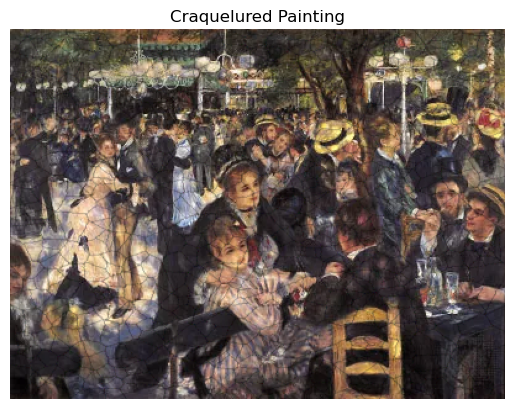

In [3]:
clean = Image.open(f"../data/sample-image-canvas-oil-Le-Moulin-de-la-Galette-1876.png").convert("RGB")
mask = Image.open(f"../data/crack-masks/0.jpg").convert("L")  # grayscale

craquelured_1 = apply_realistic_craquelure(
    clean,
    mask,
    alpha=0.8,     # make cracks more visible
    blur=1,        # retain sharpness
    noise=0.03     # add some texture variation
)

plt.imshow(craquelured_1)
plt.axis('off')
plt.title("Craquelured Painting")
plt.show()

## Experiment 2: Adding Augmentations to the Masks

In [4]:
import albumentations as A
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def augment_and_blend_craquelure(clean_image, crack_mask, alpha=0.9):
    """
    Augment a crack mask and blend it with the painting to simulate craquelure.
    Applies only flipping, brightness/contrast, and subtle color variation.
    Dilation is removed to preserve fine cracks.

    Args:
        clean_image (PIL.Image): RGB image of the painting.
        crack_mask (PIL.Image): Grayscale crack mask.
        alpha (float): Opacity of the crack overlay (0 = invisible, 1 = strong).

    Returns:
        PIL.Image: Craquelured painting.
    """

    # Convert to NumPy arrays
    img_np = np.array(clean_image).astype(np.float32) / 255.0
    mask_np = np.array(crack_mask.convert("L").resize(clean_image.size)).astype(np.uint8)

    # Stage 1: Augment the crack mask
    mask_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)
    ])
    augmented = mask_aug(image=mask_np)
    aug_mask = augmented["image"].astype(np.float32) / 255.0

    # Strengthen mask (no dilation)
    aug_mask = np.clip(aug_mask * 1.5, 0, 1)
    aug_mask = cv2.GaussianBlur(aug_mask, (3, 3), sigmaX=0.5)
    aug_mask_3c = np.stack([aug_mask] * 3, axis=-1)

    # Visualize the augmented mask
    plt.imshow(aug_mask, cmap='gray')
    plt.title("Augmented Crack Mask (No Dilation)")
    plt.axis('off')
    plt.show()

    # Stage 2: Blend darker crack texture
    dark_crack = np.ones_like(img_np) * [0.25, 0.22, 0.18]
    blend_aug = A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=1.0),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=1.0)
    ])
    blend_dark_crack = blend_aug(image=(dark_crack * 255).astype(np.uint8))["image"].astype(np.float32) / 255.0

    # Final blending
    craquelured_np = img_np * (1 - alpha * aug_mask_3c) + blend_dark_crack * (alpha * aug_mask_3c)
    craquelured_img = Image.fromarray((craquelured_np * 255).astype(np.uint8))
    
    return craquelured_img


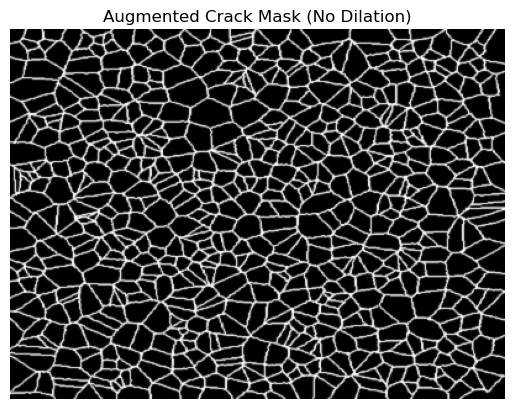

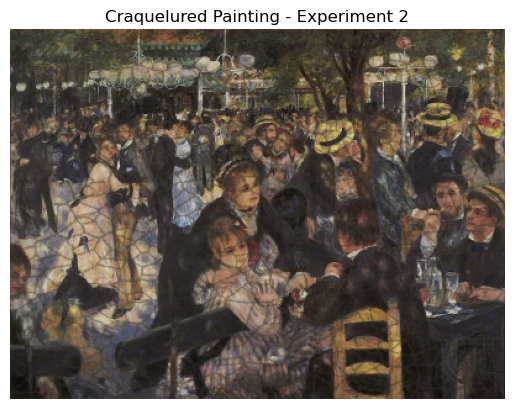

In [5]:
craquelured_2 = augment_and_blend_craquelure(clean, mask, alpha=0.6)

plt.imshow(craquelured_2)
plt.axis('off')
plt.title("Craquelured Painting - Experiment 2")
plt.show()

## Experiment 3: Modify Function to Produce Tuple (Damaged Image and Mask Only)

In [6]:
import albumentations as A
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def augment_craquelure_with_mask_output(clean_image, crack_mask_input, alpha=0.9):
    """
    Augment a crack mask and blend it with the painting to simulate craquelure.
    Applies flipping, brightness/contrast, and subtle color variation.
    Returns the craquelured painting and the final augmented binary mask used.

    Args:
        clean_image (PIL.Image): RGB image of the painting.
        crack_mask_input (PIL.Image): Grayscale crack mask (this will be augmented).
        alpha (float): Opacity of the crack overlay (0 = invisible, 1 = strong).

    Returns:
        tuple: (craquelured_pil_img, final_binary_mask_pil)
               craquelured_pil_img (PIL.Image): The image with craquelure applied.
               final_binary_mask_pil (PIL.Image): The augmented and processed binary
                                                  mask (mode 'L', 0-255) that was used
                                                  to create the craquelure effect."""
    # Ensure that input image is in RGB
    if clean_image.mode != 'RGB':
        clean_image = clean_image.convert('RGB')
    img_np = np.array(clean_image).astype(np.float32)/255.0

    mask_np = np.array(crack_mask_input.convert('L').resize(clean_image.size)).astype(np.uint8)

    # Augment the mask to be used
    mask_aug_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)
    ])
    augmented = mask_aug_transform(image=mask_np)
    aug_mask_float = augmented['image'].astype(np.float32)/255.0

    aug_mask_strengthened = np.clip(aug_mask_float * 1.5, 0, 1)
    aug_mask_blurred = cv2.GaussianBlur(aug_mask_strengthened, (3, 3), sigmaX=0.5)

    aug_mask_3c_for_blending = np.stack([aug_mask_blurred] * 3, axis = -1)

    dark_crack_base_color_np = np.array([0.25, 0.22, 0.18], dtype=np.float32)

    dark_crack_texture_np = np.ones_like(img_np) * dark_crack_base_color_np

    blend_aug_transform = A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.8),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), per_channel=True, p=0.8)
    ])

    # Albumentations expects uint8 input for these color transforms
    blend_dark_crack_texture_uint8 = (dark_crack_texture_np * 255).astype(np.uint8)
    augmented_dark_crack_texture_uint8 = blend_aug_transform(image=blend_dark_crack_texture_uint8)["image"]
    augmented_dark_crack_texture_float = augmented_dark_crack_texture_uint8.astype(np.float32) / 255.0

    # Final blending using the augmented mask
    # Alternative blending: Lerp for smoother transition based on mask intensity
    craquelured_np = (img_np * (1 - aug_mask_3c_for_blending * alpha)) + \
                     (augmented_dark_crack_texture_float * (aug_mask_3c_for_blending * alpha))

    craquelured_np = np.clip(craquelured_np, 0, 1) # Ensure values are within [0,1]
    
    # Convert final damaged image back to PIL
    craquelured_pil_img = Image.fromarray((craquelured_np * 255).astype(np.uint8))
    
    # Prepare the final binary mask to be returned (the one used for blending)
    # This should be a grayscale PIL image (0-255 range)
    final_mask_for_output_np = (aug_mask_blurred * 255).astype(np.uint8)
    final_binary_mask_pil = Image.fromarray(final_mask_for_output_np, mode='L')
    
    return craquelured_pil_img, final_binary_mask_pil

### Implementing augment_and_blend_craquelure

In [7]:
# Load Image
clean = Image.open(f"../data/sample-image-canvas-oil-Le-Moulin-de-la-Galette-1876.png").convert("RGB")
mask = Image.open(f"../data/crack-masks/0.jpg").convert("L")  # grayscale

In [8]:
# Call function
damaged_output, ground_truth_mask = augment_craquelure_with_mask_output(clean, mask, alpha=0.9)

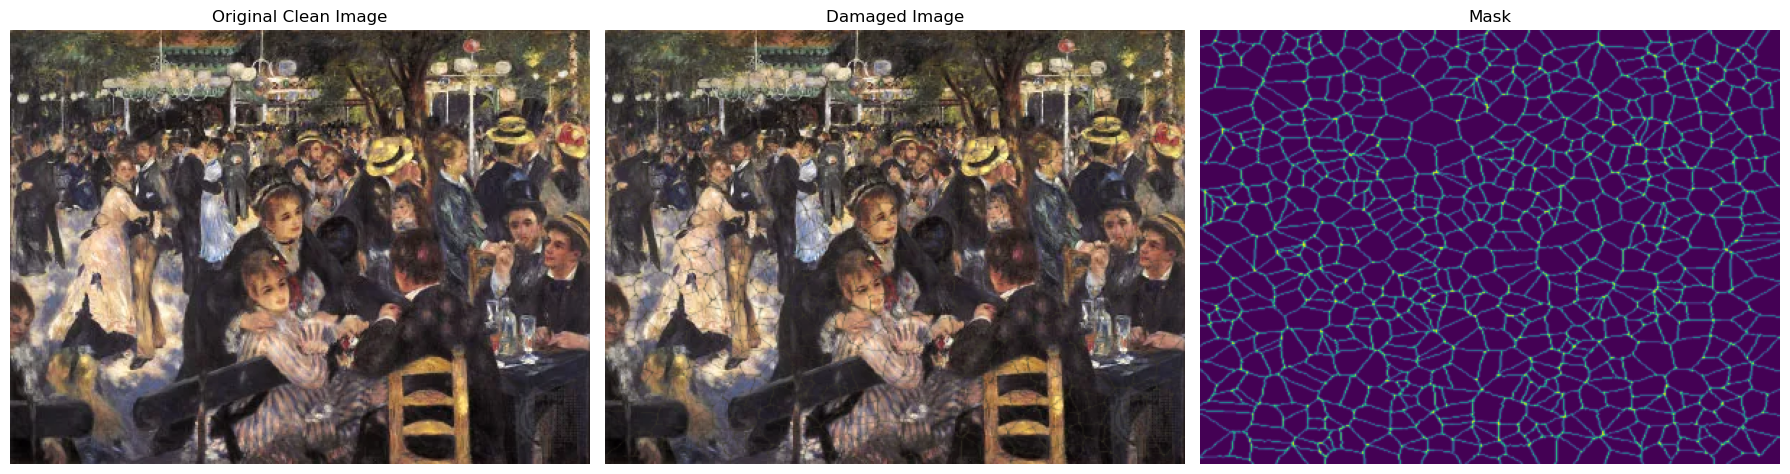

In [9]:
# Display results

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(clean)
axes[0].set_title("Original Clean Image")
axes[0].axis('off')

axes[1].imshow(damaged_output)
axes[1].set_title("Damaged Image")
axes[1].axis('off')

axes[2].imshow(ground_truth_mask)
axes[2].set_title("Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()